# Training a NMNIST classifier

This tutorial combine [norse](norse.ai) library  with NMNIST dataset.  The aim of the project is classify hand-written digits using Spiking Neural Network.

## Install and Imports

You can just run and skip this part. Here we import all the necessary.

### Install 

We can simply install Tonic and Norse through pip:

In [1]:
!pip install tonic
!pip install --quiet norse

### Import

In [2]:
import torch
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from typing import NamedTuple
from tqdm.notebook import tqdm, trange

import tonic
import tonic.transforms as transforms

from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell
# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState
from norse.torch import SpikeLatencyLIFEncoder
from norse.torch import ConstantCurrentLIFEncoder

torch.manual_seed(1234)

## Parameters

But first of all we define all the parameters that we will need after.

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Tonic transformation parameters
n_time_bins = 12
T = n_time_bins
# SNN parameters
LR = 0.002
INPUT_FEATURES = 2312
HIDDEN_FEATURES = 300
OUTPUT_FEATURES = 10
# Training parameters
BATCH_SIZE = 256
EPOCHS  = 10

DEVICE

device(type='cuda')

## NMINST Dataset

The N-MNIST dataset was captured by mounting the ATIS sensor on a motorized pan-tilt unit and having the sensor move while it views MNIST examples on an LCD monitor as shown in this video.

In [4]:
sensor_size = tonic.datasets.NMNIST.sensor_size

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[1000]

frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=n_time_bins) 
frames = frame_transform(events)

sensor_size

(34, 34, 2)

### Visualization from dataset

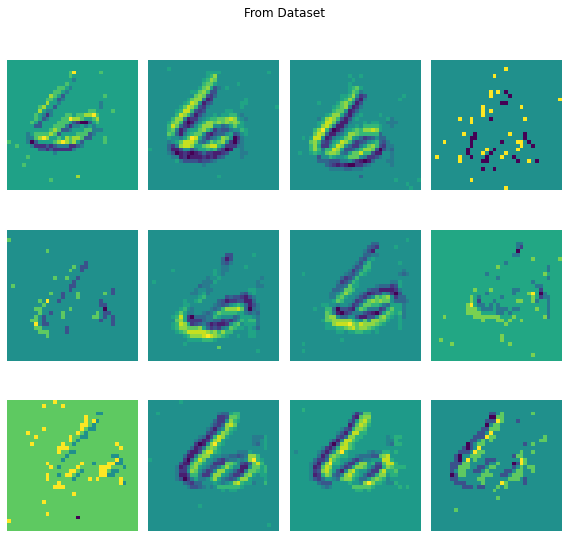

In [5]:
columns = 4
rows = 3

def plot_frames(frames, title):
    fig = plt.figure(figsize=(8, 8))
    plt.suptitle(title)
    for i in range(len(frames)):
      fig.add_subplot(rows, columns, i + 1)
      plt.imshow(frames[i][1]-frames[i][0])
      plt.axis('off')
    plt.tight_layout()
        
plot_frames(frames, "From Dataset")

### Visualization after denoising

In practise means that an event is dropped if no other event occured within a spatial neighbourhood of 1 pixel and a temporal neighbourhood of filter_time time units.

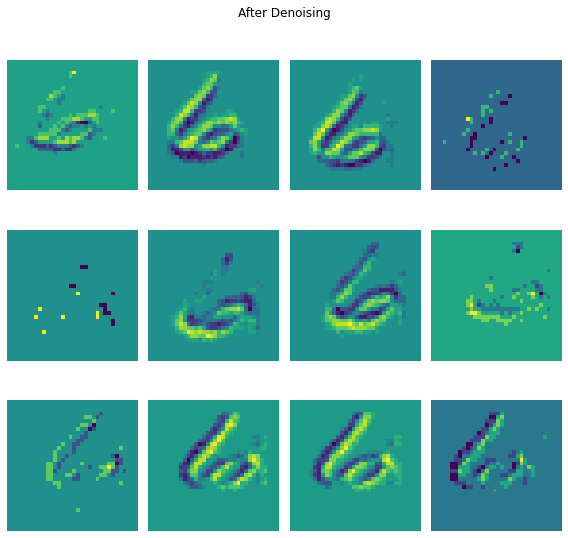

In [6]:
denoise_transform = tonic.transforms.Denoise(filter_time=10000)

events_denoised = denoise_transform(events)
frames_denoised = frame_transform(events_denoised)

plot_frames(frames_denoised, "After Denoising")

### Combining and preparing for Pytorch

Here we define the `train_loader` and the `test_loader`.

torch.Size([12, 2, 34, 34])


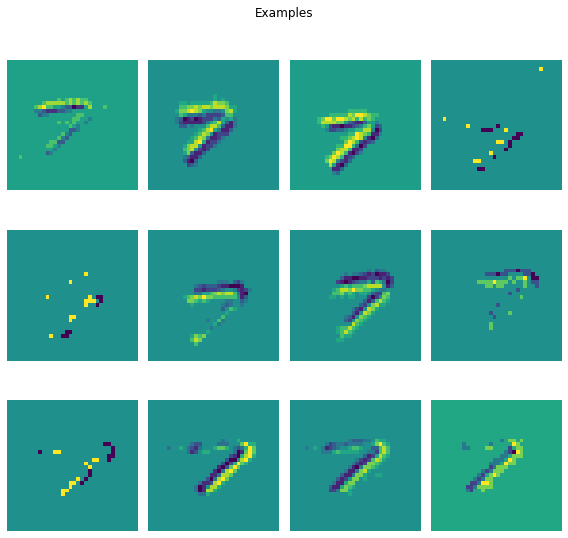

In [7]:
transform = transforms.Compose([denoise_transform, frame_transform])

train_set = tonic.datasets.NMNIST(save_to='./data',
                                train=True,
                                transform=transform)

test_set = tonic.datasets.NMNIST(save_to='./data',
                                train=False,
                                transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE) # , batch_size=BATCH_SIZE
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=BATCH_SIZE) # , batch_size=BATCH_SIZE
frames, target = next(iter(train_loader))

frames, target = frames[0], target[0]

print(frames.shape)
plot_frames(frames.squeeze(), "Examples")

## Defining the Model

Here we define the model, it will be used later. The output of the network we have defined are $10$ membrane voltage traces. We determine the maximum along the time dimension and then compute the softmax of these values.

In [8]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

class Model(torch.nn.Module):
    def __init__(self, snn, decoder):
        super(Model, self).__init__()
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

### Training step

What remains to do is to setup training code

In [9]:
def train(model, device, train_loader, optimizer, epoch, test_loss, accuracy, max_epochs):
    model.train()
    losses = []
    pbar = tqdm(train_loader, leave=False)
    for (data, target) in pbar:
        pbar.set_description('Epoch {} / {} '.format(epoch, max_epochs))
        data, target = data.float().to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        pbar.set_postfix(
            {
              'Train loss (in progress)': loss.item(),
              'Accuracy (test set)': accuracy,
              'Loss (test set)': test_loss
            }
        )
        
    mean_loss = np.mean(losses)
    return losses, mean_loss

###  Testing step

and test code.

In [10]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.float().to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

## Defining a FCNN


Here we define a spiking neural network with one recurrently connected layer
with `hidden_features` LIF neurons and a readout layer with `output_features` and leaky-integrators.

In [11]:
class SNNState(NamedTuple):
    lif0 : LIFState
    readout : LIState


class SNN(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features, record=False, dt=0.001):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt                     
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record
        

        
    def forward(self, x):
        batch_size, seq_length, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
          self.recording = SNNState(
              LIFState(
                z = torch.zeros(seq_length, batch_size, self.hidden_features),
                v = torch.zeros(seq_length, batch_size, self.hidden_features),
                i = torch.zeros(seq_length, batch_size, self.hidden_features)
              ),
              LIState(
                v = torch.zeros(seq_length, batch_size, self.output_features),
                i = torch.zeros(seq_length, batch_size, self.output_features)
              )
          )

        for ts in range(seq_length):
            z = x[:, ts, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
              self.recording.lif0.z[ts,:] = s1.z
              self.recording.lif0.v[ts,:] = s1.v
              self.recording.lif0.i[ts,:] = s1.i
              self.recording.readout.v[ts,:] = so.v
              self.recording.readout.i[ts,:] = so.i
            voltages += [vo]

        return torch.stack(voltages)

We can visualize the output produced by the recurrent spiking neural network on the example input.

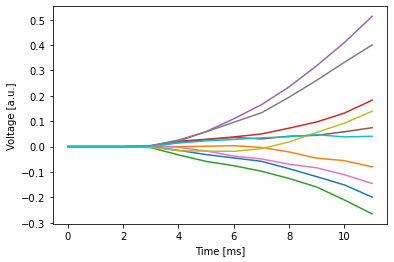

In [12]:
example_snn = SNN(2312, 300, 10, record=True, dt=0.0005)
example_readout_voltages = example_snn(frames.float().unsqueeze(0))
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel('Voltage [a.u.]')
plt.xlabel('Time [ms]')
plt.show()

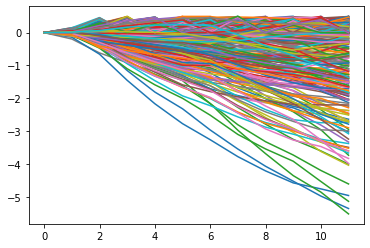

In [13]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

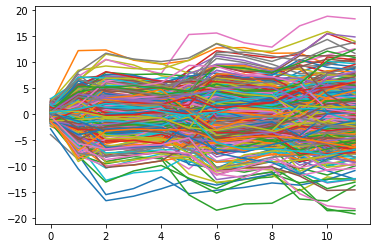

In [14]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

### Training the Network

The final model is then simply the sequential composition of these two steps: a spiking neural network and decoder.

In [15]:
model = Model(
    snn=SNN(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES
    ),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=2312, hidden_size=300, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=300, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

### Training Process

Here we are effectively training the model.

In [16]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)
test_loss = 0.0
accuracy = 0.0
for epoch in range(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, test_loss, accuracy, max_epochs=EPOCHS)
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

final accuracy: 95.41


### Results visualization 

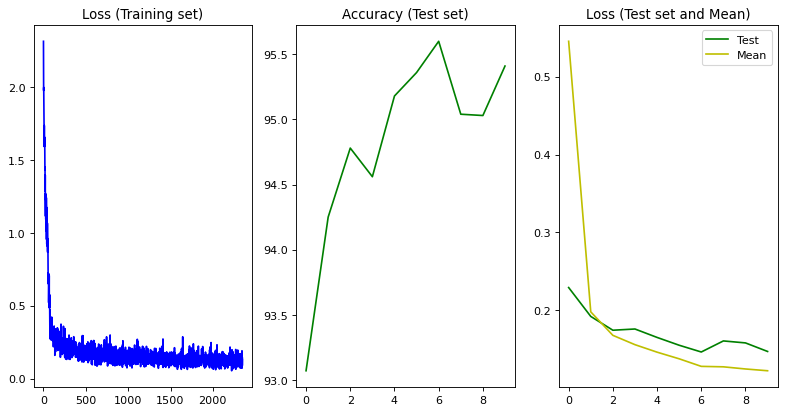

In [17]:
plt.figure(figsize=(12, 6), dpi=80)

x_values =  [i for i in range(len(accuracies))]
x_values_loss = [i for i in range(len(training_losses))]

ax2 = plt.subplot(1, 3, 1)
plt.plot(x_values_loss,training_losses, 'b-', label="Training")
ax2.set_title('Loss (Training set)')

ax1 = plt.subplot(1, 3, 2)
plt.plot(x_values,accuracies, 'g-', label="Test")
ax1.set_title('Accuracy (Test set)')

ax2 = plt.subplot(1, 3, 3)
plt.plot(x_values, test_losses, 'g-', label="Test")
plt.plot(x_values, mean_losses, 'y-', label="Mean")
plt.legend(loc="upper right")
ax2.set_title('Loss (Test set and Mean)')

plt.show()

## Defining a CNN

In [27]:
class SNNState(NamedTuple):
    lif0 : LIFState
    readout : LIState


class ConvNet(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features, num_channels=2, record=False, dt=0.001, method="super", alpha=100):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(num_channels, 30, 5, 1)
        self.conv2 = torch.nn.Conv2d(30, 70, 5, 1)
        self.flatten = torch.nn.Flatten()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt                     
        )

        self.lif0 = LIFCell(dt=dt, p=LIFParameters(method=method, alpha=alpha))
        self.lif1 = LIFCell(dt=dt, p=LIFParameters(method=method, alpha=alpha))
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record
        

        
    def forward(self, x):
        batch_size, seq_length, _, _, _ = x.shape
        s0 = s1 = s2 = so = s3 = None
        voltages = []

        if self.record:
          self.recording = SNNState(
              LIFState(
                z = torch.zeros(seq_length, batch_size, self.hidden_features),
                v = torch.zeros(seq_length, batch_size, self.hidden_features),
                i = torch.zeros(seq_length, batch_size, self.hidden_features)
              ),
              LIState(
                v = torch.zeros(seq_length, batch_size, self.output_features),
                i = torch.zeros(seq_length, batch_size, self.output_features)
              )
          )

        for ts in range(seq_length):
            z = x[:, ts, :, :]
            z = self.conv1(z)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z, s0 = self.lif0(z, s0)
            z = self.conv2(z)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z, s2 = self.lif1(z, s2)
            z = self.flatten(z)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
              self.recording.lif0.z[ts,:] = s1.z
              self.recording.lif0.v[ts,:] = s1.v
              self.recording.lif0.i[ts,:] = s1.i
              self.recording.readout.v[ts,:] = so.v
              self.recording.readout.i[ts,:] = so.i
            voltages += [vo]

        return torch.stack(voltages)

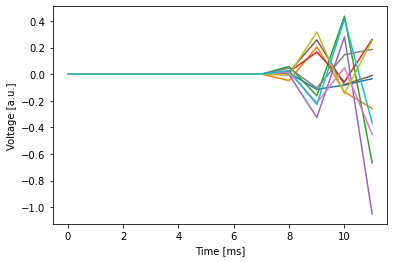

In [28]:
example_snn = ConvNet(1750, 1000, 10, record=True, dt=0.01)
example_readout_voltages = example_snn(frames.float().unsqueeze(0))

plt.plot(example_readout_voltages.squeeze(1).detach().numpy())
plt.ylabel('Voltage [a.u.]')
plt.xlabel('Time [ms]')
plt.show()

### Training the Network

The final model is then simply the sequential composition of these two steps: a spiking neural network and decoder.

In [31]:
INPUT_FEATURES = 1750
HIDDEN_FEATURES = 1000
model = Model(
    snn=ConvNet(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES,
      dt=0.01
    ),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (snn): ConvNet(
    (conv1): Conv2d(2, 30, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(30, 70, kernel_size=(5, 5), stride=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (l1): LIFRecurrentCell(input_size=1750, hidden_size=1000, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.01)
    (lif0): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100)), dt=0.01)
    (lif1): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100)), dt=0.01)
    (fc_out): Linear(in_features=1000, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), 

### Training Process

Here we are effectively training the model.

In [ ]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)
test_loss = 0.0
accuracy = 0.0
for epoch in range(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, test_loss, accuracy, max_epochs=EPOCHS)
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/235 [00:00<?, ?it/s]

### Results visualization 

In [ ]:
plt.figure(figsize=(12, 6), dpi=80)

x_values =  [i for i in range(len(accuracies))]
x_values_loss = [i for i in range(len(training_losses))]

ax2 = plt.subplot(1, 3, 1)
plt.plot(x_values_loss,training_losses, 'b-', label="Training")
ax2.set_title('Loss (Training set)')

ax1 = plt.subplot(1, 3, 2)
plt.plot(x_values,accuracies, 'g-', label="Test")
ax1.set_title('Accuracy (Test set)')

ax2 = plt.subplot(1, 3, 3)
plt.plot(x_values, test_losses, 'g-', label="Test")
plt.plot(x_values, mean_losses, 'y-', label="Mean")
plt.legend(loc="upper right")
ax2.set_title('Loss (Test set and Mean)')

plt.show()